In [3]:
%pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools numpy;

  Using cached tensorflow_datasets-4.5.2-py3-none-any.whl (4.2 MB)
  Using cached matplotlib-3.5.1-cp38-cp38-win_amd64.whl (7.2 MB)
  Using cached pycocotools-2.0.4.tar.gz (106 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
  Using cached promise-2.3.tar.gz (19 kB)
  Using cached importlib_resources-5.7.1-py3-none-any.whl (28 kB)
  Using cached tensorflow_metadata-1.7.0-py3-none-any.whl (48 kB)
  Using cached fonttools-4.32.0-py3-none-any.whl (900 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached Pillow-9.1.0-cp38-cp38-win_amd64.whl (3.3 MB)
  Using cached kiwisolver-1.4.2-cp38-cp38-win_am

You should consider upgrading via the 'C:\Users\bosq\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\bosq\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [2]:
%pip install opencv-python

You should consider upgrading via the 'C:\Users\bosq\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_labels_paper import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
from keras import backend as K
import random

C:\Users\bosq\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRAIN_IMAGES = 'data/coco_onehot_train'
VAL_IMAGES = 'data/coco_onehot_val'

In [3]:
resnet50 = keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(224,224,3))
resnet50.summary()
resnet50.trainable = True

94683136/94668760 [==============================] - 2s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [4]:
BOTTLENECK_DEPTH = 16

input = Input(shape=(224,224,3))
encoder = resnet50(input)
encoder_output = Conv2D(BOTTLENECK_DEPTH, 1, activation="relu", padding="same")(encoder)

encoder_model = Model(inputs=[input], outputs=encoder_output)
#encoder_model.summary()

decoder_input = Input(shape=(7,7,BOTTLENECK_DEPTH))
x = Conv2DTranspose(512, 3, 2, padding="same", activation="relu")(decoder_input)
x = Conv2DTranspose(256, 3, 2, padding="same", activation="relu")(x)
x = Conv2DTranspose(128, 3, 2, padding="same", activation="relu")(x)
x = Conv2DTranspose(64, 3, 2, padding="same", activation="relu")(x)
x = Conv2DTranspose(3, 3, 2, padding="same", activation="sigmoid")(x)

decoder_model = Model(inputs=decoder_input, outputs=x)
#decoder_model.summary()



autoencoder_input = Input(shape=(224,224,3))
encoder_block = encoder_model(autoencoder_input)
decoder_block = decoder_model(encoder_block)
autoencoder_model = Model(inputs=autoencoder_input, outputs=decoder_block)
autoencoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 7, 7, 16)          23597584  
                                                                 
 model_1 (Functional)        (None, 224, 224, 3)       1624707   
                                                                 
Total params: 25,222,291
Trainable params: 25,176,851
Non-trainable params: 45,440
_________________________________________________________________


In [5]:
train_files = {}
for d in os.listdir(TRAIN_IMAGES):
    files = os.listdir(f"{TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        train_files[d] = files

print(len(train_files))

val_files = {}
for d in os.listdir(VAL_IMAGES):
    files = os.listdir(f"{VAL_IMAGES}/{d}")
    if len(files) > 0:
        val_files[d] = files

print(len(val_files))

80
70


In [51]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomRotation(
            factor=0.15, fill_mode="nearest"
        ),
        tf.keras.layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        )
    ]
)

def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img/255.0
    return img

def preprocess_twins(anchor, autoencoded):
    x = load_images(anchor)
    #x = data_augmentation(x, training=True)
    #x = tf.image.stateless_random_hue(x, max_delta=0.2, seed=(1,2))
    y = load_images(autoencoded)
    return (x, y)

def get_training_data(epoch_size=1024, training: bool=True):
    X = []
    Y = []

    image_set = train_files if training else val_files
    image_dir = TRAIN_IMAGES if training else VAL_IMAGES

    available_classes = list(image_set.keys())

    for i in range(epoch_size):

        c = random.choice(available_classes)
        anchor = random.choice(image_set[c])

        X.append(f"{image_dir}/{c}/{anchor}")
        Y.append(f"{image_dir}/{c}/{anchor}")

    return (X, Y)

def get_training_dataset(epoch_size=1024, training: bool=True):
    data = get_training_data(epoch_size, training)
    x = tf.data.Dataset.from_tensor_slices(data[0])
    y = tf.data.Dataset.from_tensor_slices(data[1])
    final_data = tf.data.Dataset.zip((x,y))
    processed_data = final_data.map(preprocess_twins)
    return processed_data


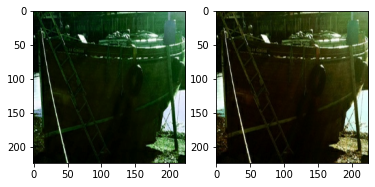

In [7]:
dasd = get_training_dataset(1024).take(1).as_numpy_iterator()

batch = next(dasd)
img1 = np.array(batch[0])
img2 = np.array(batch[1])

#img1 = data_augmentation(img1)

f, axarr = plt.pyplot.subplots(1,2)
axarr[0].imshow(img1)
axarr[1].imshow(img2)

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder_model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, metrics=METRICS, loss_weights=[10,80])
#autoencoder_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/autoencoder

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/autoencoder/{0}'.format(current_time)
weight_dir = 'weights/autoencoder/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)

ERROR: Failed to launch TensorBoard (exited with 1).

In [11]:
class opencv_draw_callback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        if batch % 100 == 0:
            data = get_training_dataset(1, False).as_numpy_iterator()
            data = next(data)
            pred = autoencoder_model.predict(data[0].reshape(-1,224,224,3))
            stack = np.hstack((data[0], pred[0]))
            cv2.imshow("inputoutput", stack)
            cv2.waitKey(1000)

opencv_callback = opencv_draw_callback()

In [12]:

train_data = get_training_dataset(4096*64)
train_data = train_data.batch(32)
train_data = train_data.prefetch(32)

val_data = get_training_dataset(1024, False)
val_data = val_data.batch(32)
val_data = val_data.prefetch(32)

# print(len(data[2]))
loss = autoencoder_model.fit(train_data, batch_size=16, epochs=20, steps_per_epoch=1000, validation_data=val_data, callbacks=[
    tensorboard_callback, opencv_callback])
print(loss)


C:\Users\bosq\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
1000/1000 [==============================] - 449s 427ms/step - loss: 5.4575 - tp: 1576313600.0000 - fp: 1277909.0000 - tn: 107882912.0000 - fn: 3131423232.0000 - accuracy: 0.0285 - precision: 0.9992 - recall: 0.3348 - auc: 0.8740 - prc: 0.9963 - val_loss: 5.3278 - val_tp: 65887608.0000 - val_fp: 37948.0000 - val_tn: 3771169.0000 - val_fn: 84443952.0000 - val_accuracy: 0.0308 - val_precision: 0.9994 - val_recall: 0.4383 - val_auc: 0.9247 - val_prc: 0.9977
Epoch 2/20
1000/1000 [==============================] - 435s 434ms/step - loss: 5.2029 - tp: 1723604352.0000 - fp: 280394.0000 - tn: 108999776.0000 - fn: 2984011776.0000 - accuracy: 0.0294 - precision: 0.9998 - recall: 0.3661 - auc: 0.9293 - prc: 0.9981 - val_loss: 5.2078 - val_tp: 58879052.0000 - val_fp: 15335.0000 - val_tn: 3793782.0000 - val_fn: 91452504.0000 - val_accuracy: 0.0309 - val_precision: 0.9997 - val_recall: 0.3917 - val_auc: 0.9325 - val_prc: 0.9980
Epoch 3/20
1000/1000 [==============================] - 435s 

In [13]:

encoder_model.save(os.path.join("weights/autoencoder", "autoencoder"),)


INFO:tensorflow:Assets written to: weights/autoencoder\autoencoder\assets


C:\Users\bosq\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\bosq\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [3]:
encoder_model = tf.keras.models.load_model(os.path.join("weights/autoencoder", "autoencoder"))

2022-04-18 10:40:13.648903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 10:40:13.655631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 10:40:13.655781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 10:40:13.656366: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [65]:
data = get_training_dataset(20000, False).as_numpy_iterator()

X = []

for i,x in enumerate(data):
    preds = encoder_model.predict(np.array(x[0]).reshape(-1,224,224,3))
    X.append(preds)

In [66]:
flattened = [np.ndarray.flatten(y) for y in X]

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.mixture import GaussianMixture

In [67]:
full_components = len(flattened[1])
full_components

784

In [68]:
# pca = PCA(n_components=50)
# pca.fit(flattened)
kmeans = KMeans(init='k-means++', max_iter=1000, n_clusters=90, n_init=5)
kmeans.fit(flattened)

#gm = GaussianMixture(n_components=90).fit(flattened)

#clustering_predictions = zip(kmeans.predict(flattened), flattened)

KMeans(max_iter=1000, n_clusters=90, n_init=5)

In [69]:
import time
data = get_training_dataset(500, True).as_numpy_iterator()

clustermap = {}

for img, _ in data:
    pred = encoder_model.predict(img.reshape(-1,224,224,3))
    cluster = kmeans.predict([np.ndarray.flatten(pred)])[0]
    print(cluster)
    if cluster not in clustermap:
        clustermap[cluster] = list()
    clustermap[cluster].append(img)
# for i,x in enumerate(X):
#     p = decoder_model.predict(x)
#     #cv2.imshow("decoder_out", p[0])
#     cluster = clustering.predict(np.ndarray.flatten(x).reshape(1,-1).astype(float))
#     #print(cluster)
#     #cv2.waitKey(1000)
#     cluster_output.append((cluster, p[0]))

85
16
36
37
30
27
6
14
85
34
14
47
30
10
23
6
56
51
8
1
73
11
73
10
54
27
51
54
81
85
76
10
47
36
14
1
9
23
10
81
10
37
49
30
37
30
7
27
14
10
44
27
10
36
80
14
23
36
49
85
10
10
32
9
49
6
76
54
16
6
81
81
49
16
54
41
81
10
27
73
73
76
37
30
34
59
10
6
81
8
37
14
23
16
58
80
8
58
36
81
30
10
58
73
16
50
73
85
58
10
27
30
23
16
10
16
73
56
49
58
30
85
58
73
85
73
1
7
37
14
14
10
27
41
81
49
85
30
76
85
23
44
44
30
85
9
36
54
8
23
49
6
10
27
54
32
61
47
30
73
23
10
10
10
10
34
27
8
27
49
16
10
16
34
11
10
30
76
9
76
47
58
14
10
76
80
85
11
14
58
14
37
54
10
10
1
81
41
10
27
10
86
14
6
14
11
85
41
8
7
14
30
14
81
27
37
58
47
47
49
10
14
23
58
85
30
49
30
30
37
81
54
1
56
47
14
41
34
73
47
51
58
27
30
85
66
30
11
58
30
73
85
14
10
76
37
81
10
73
30
76
33
81
49
59
54
58
41
30
85
10
80
73
49
73
30
54
14
14
27
47
30
6
54
58
81
14
54
30
58
73
10
8
10
30
9
16
54
47
14
66
85
54
37
76
34
30
58
10
6
10
47
30
14
10
11
16
11
32
27
14
9
1
41
16
85
27
34
59
73
36
27
81
23
27
51
8
47
11
9
16
1
30
54
54

<BarContainer object of 40 artists>

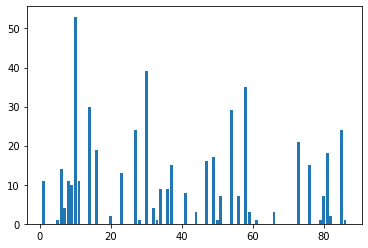

In [70]:
clustersizes = [len(clustermap[c]) for c in clustermap]
clusterindeces = [c for c in clustermap]
plt.pyplot.bar(clusterindeces, clustersizes)

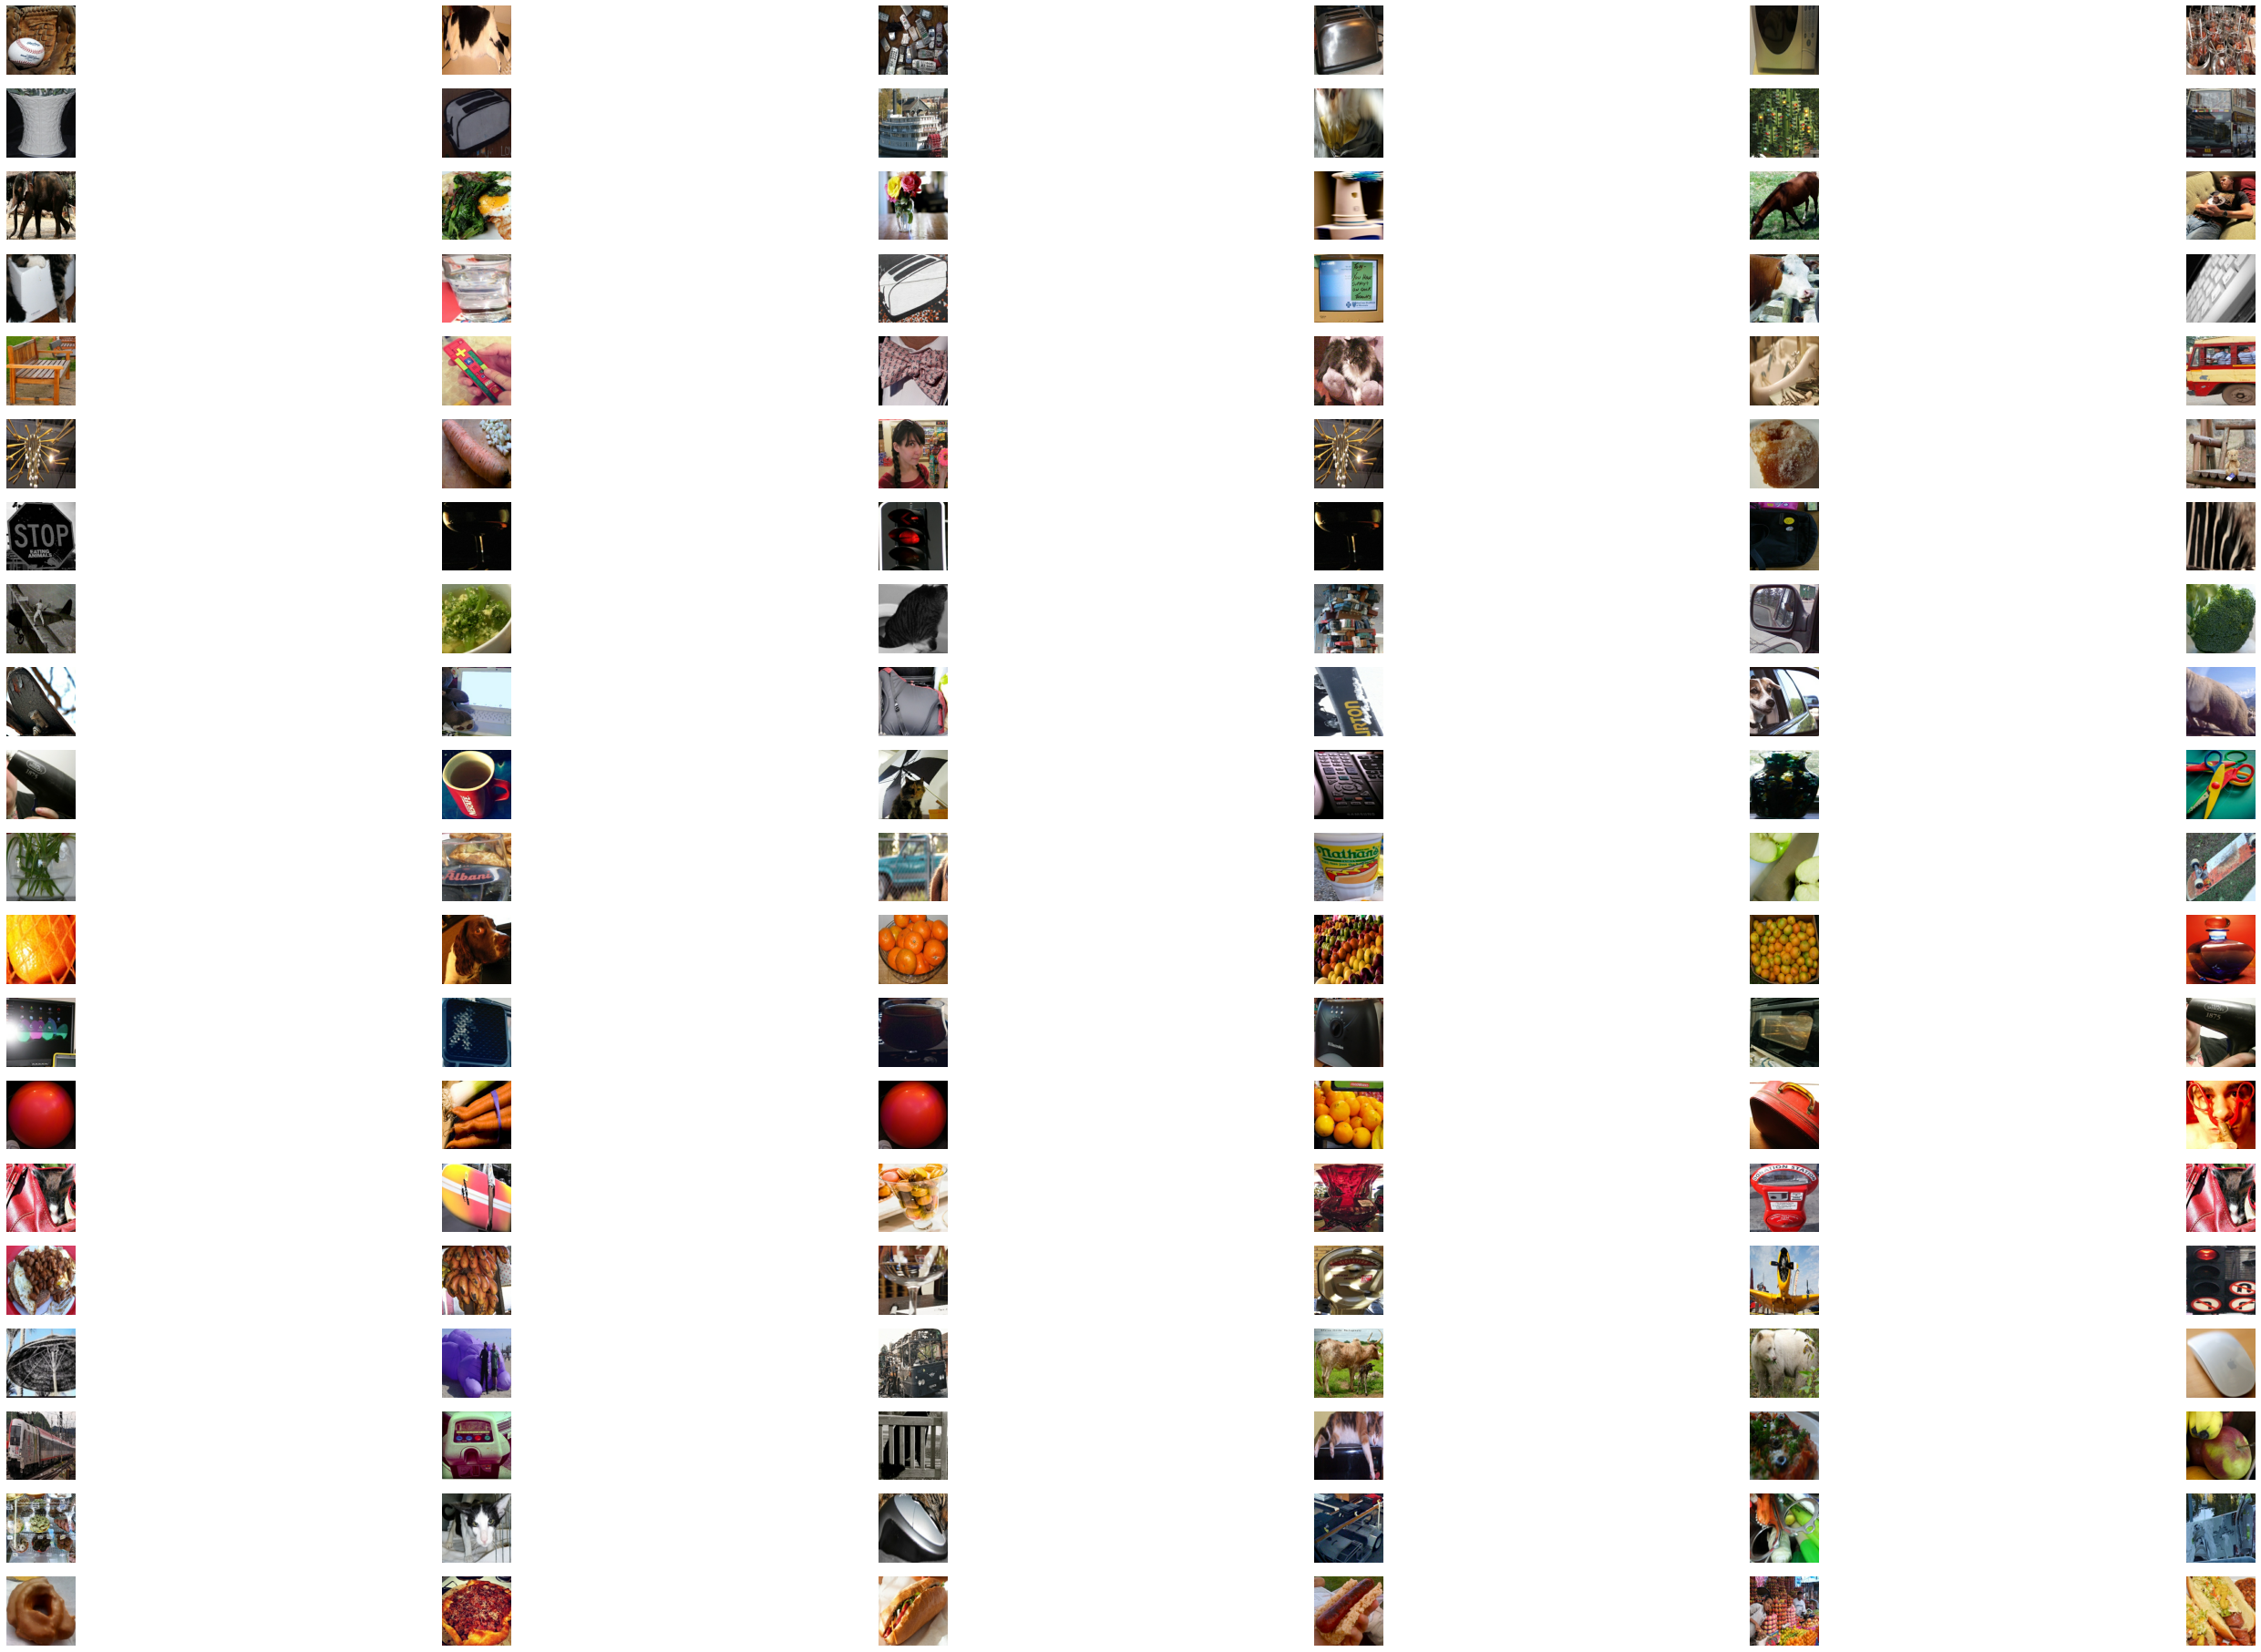

In [71]:
num_images = 6
plt.pyplot.figure(figsize=(50, 200))
position = 1
max_clusters = num_images*20

for c in clustermap:
    imgs = clustermap[c]
    for j in range(num_images):
        img = np.ones((32,32,3))
        if len(imgs) > j:
            img = imgs[j]
        plt.pyplot.subplot(max_clusters, num_images, position)
        plt.pyplot.imshow((img*255.0).astype("uint8"))
        plt.pyplot.axis("off")
        position += 1
        
    if position > max_clusters:
        break

plt.pyplot.savefig("clsuters.jpg")
# for c in range(90):
#     for j in range(num_images):
#         if len(cluster_instances) <= num_images:
#             continue
#         image_idx = cluster_instances[j][0]
#         plt.subplot(90, num_images, position)
#         plt.imshow((x_train[image_idx]*255.0).astype("uint8"))
#         #plt.title(classes[y_data[image_idx][0]])
#         plt.axis("off")
#         position += 1

In [15]:
cv2.destroyAllWindows()